In [57]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import sys
import os

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from copy import deepcopy
from corner import corner

# Add the path to the symbolic_pofk module
sys.path.append(os.path.join(sys.path[0], 'hybridStats'))
from torch_codes.models import MDN,mdn_loss,SimpleCNN

In [41]:
# define the path to save the results
out_dir = '/home/suice/workspace/play_ground/experiment_results/ex_npe_test'

### Load data

In [3]:
total_img = np.load('/home/suice/workspace/play_ground/dataset/train_data/final_data/img_train.npy') #raw imgs
total_ps = np.load('/home/suice/workspace/play_ground/dataset/train_data/final_data/ps_train.npy') # power spectrum as base summaries
params = np.load('/home/suice/workspace/play_ground/dataset/train_data/final_data/params_train.npy')

total_img_test  = np.load('/home/suice/workspace/play_ground/dataset/train_data/final_data/img_test.npy')

In [4]:
X = torch.tensor(total_img/50).float()
X = X.unsqueeze(1)
X_test = torch.tensor(total_img_test/50).float()
X_test = X_test.unsqueeze(1)

S = torch.tensor(total_ps).float()

thetas = torch.tensor(params).float()

In [5]:
X.shape, S.shape, thetas.shape

(torch.Size([9998, 1, 64, 64]), torch.Size([9998, 11]), torch.Size([9998, 2]))

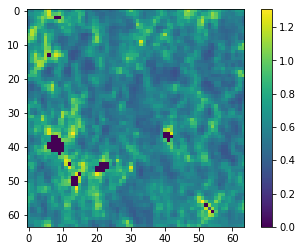

In [6]:
idx = np.random.randint(len(X))
plt.imshow(X[idx,0].numpy())
plt.colorbar()

In [7]:
#train eval split
from sklearn.model_selection import train_test_split
X_train, X_eval, S_train, S_eval,  thetas_train, thetas_eval = train_test_split(X, S,  thetas, test_size=0.2, random_state=42)

## Training the SummaryNet

In [15]:

class total_model(nn.Module):
    def __init__(self,compressor,mdn):
        '''
        we have two neural networks one for the compressor and one for the MI maximization
        this is a model that combines the two

        Args:
            :compressor: the neural network that compresses the image
            :mdn: mixture density network for calculating the EPE loss

        '''
        super(total_model, self).__init__()

        self.compressor = compressor
        self.mdn = mdn

    def forward(self, img, sum,theta):

        extra_sum = self.compressor(img)
        total_cond = torch.cat([extra_sum,sum],dim=1)

        # get negative log likelihood
        pi, sigma, mu = self.mdn(total_cond)
        loss = mdn_loss(pi, sigma, mu, theta)

        return loss
    

def augument(imgs):
    '''
    Augument the images by rotating them to improve the robustness of the model
    '''

    rot_angle = np.random.choice([0, 1, 2, 3])
    # rotate
    imgs = torch.rot90(imgs, k=rot_angle, dims=[2, 3])

    return imgs

In [16]:
# training hyperparameters
batch_size = 256
epochs = 500
lr = 1e-4

# define the dim of the learned summaries
extra_dim = 2

In [17]:
#define the summary network and the mdn network
compressor = SimpleCNN(extra_dim)
mdn = MDN(extra_dim + 11, 2, 5)
model = total_model(compressor,mdn)

device = 'cuda'
optimizer = optim.Adam(model.parameters(), lr=lr)

In [19]:

train_losses = []
val_losses = []
best_val_loss = np.inf
best_compressor = None

model.to(device=device)
X, S, thetas = X.to(device), S.to(device), thetas.to(device)
X_eval, S_eval, thetas_eval = X_eval.to(device), S_eval.to(device), thetas_eval.to(device)
for epoch in range(epochs):
    model.train()
    train_loss = 0
    correct = 0
    permutation = torch.randperm(X.size(0))

    for batch in range(0, X.size(0), batch_size):

        # get a batch of data
        indices = permutation[batch:batch + batch_size]
        batch_x, batch_thetas, batch_s = X[indices], thetas[indices], S[indices]
        # batch_x, batch_thetas, batch_s = batch_x.to(device), batch_thetas.to(device), batch_s.to(device)
        batch_x = augument(batch_x)

        # optimize the model
        optimizer.zero_grad()
        loss = model(batch_x, batch_s, batch_thetas)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
    
    train_loss =  train_loss*batch_size / X.size(0)
    train_losses.append(train_loss)

    model.eval()
    val_loss = 0
    permutation = torch.randperm(X_eval.size(0))

    with torch.no_grad():
        
        for batch in range(0, X_eval.size(0), batch_size):

            indices = permutation[batch:batch + batch_size]
            batch_x, batch_thetas, batch_s = X_eval[indices], thetas_eval[indices], S_eval[indices]
            batch_x = augument(batch_x)
            
            loss = model(batch_x, batch_s, batch_thetas)
            val_loss += loss.item()
        
    val_loss =  val_loss*batch_size / X_eval.size(0)
    val_losses.append(val_loss)

    # save the best model
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_compressor = deepcopy(model.compressor)

    if epoch % 10 == 0:
        print(
            f'Epoch {epoch}: train_loss: {train_loss} val_loss: {val_loss} '
        )

Epoch 0: train_loss: 6.70876306608978 val_loss: 5.947434631347656 
Epoch 10: train_loss: 0.41431247980553143 val_loss: 0.3514190559387207 
Epoch 20: train_loss: 0.09171637038417663 val_loss: 0.09314844143390656 
Epoch 30: train_loss: 0.019944149390486006 val_loss: 0.06542789697647095 
Epoch 40: train_loss: -0.09984303259997397 val_loss: -0.09340228748321533 
Epoch 50: train_loss: -0.21322796778288763 val_loss: -0.24728095626831054 
Epoch 60: train_loss: -0.2764020113020712 val_loss: -0.33294277954101564 
Epoch 70: train_loss: -0.35092433640231463 val_loss: -0.3714511241912842 
Epoch 80: train_loss: -0.3674365143032879 val_loss: -0.18396560847759247 
Epoch 90: train_loss: -0.3672704635607908 val_loss: -0.24040548801422118 
Epoch 100: train_loss: -0.4124629704993733 val_loss: -0.09597110366821289 
Epoch 110: train_loss: -0.4920347747528021 val_loss: -0.2803696250915527 
Epoch 120: train_loss: -0.49550962820127503 val_loss: -0.1319813299179077 
Epoch 130: train_loss: -0.5014353267763538 v

In [20]:
torch.save(best_compressor.state_dict(), os.path.join(out_dir, 'compressor_epe_2extra.pth'))

In [21]:
best_compressor.eval()

#compress all X using batchsize 64
extra_S = []
for batch in range(0, X.size(0), batch_size):
    batch_x = X[batch:batch + batch_size].to(device)
    extra_S.append(best_compressor(batch_x).detach().cpu().numpy())
extra_S = np.concatenate(extra_S,axis=0)


extra_S_test = []
X_test = X_test.to(device)
for batch in range(0, X_test.size(0), batch_size):
    batch_x = X_test[batch:batch + batch_size].to(device)
    extra_S_test.append(best_compressor(batch_x).detach().cpu().numpy())
extra_S_test = np.concatenate(extra_S_test,axis=0)


In [23]:
np.save(os.path.join(out_dir,'ba_extra_2_train.npy'),extra_S)
np.save(os.path.join(out_dir,'ba_extra_2_test.npy'),extra_S_test)

## Test new summaries

### regression

In [24]:
import lightgbm as lgb
from lightgbm import early_stopping
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

In [25]:
def train_lgbm(X_train, ytrain):
    
    xtrain, xeval, ytrain, yeval = train_test_split(X_train, ytrain, test_size=0.2, random_state=42)

    dtr = lgb.LGBMRegressor(objective='regression',
                            num_leaves=31,
                            learning_rate=1e-1,
                            min_data_in_leaf=200,
                            n_estimators=200,
                            importance_type='gain',
                            random_state=1)
    
    dtr.fit(xtrain,
            ytrain,
            eval_set=[(xeval, yeval)],
            eval_metric=['l2'],
            callbacks=[early_stopping(5)])

    return dtr

def prediction_plots(ytrue, ypred, title):
    fig, ax = plt.subplots()
    r2 = r2_score(ytrue, ypred)
    rmse = np.sqrt(np.mean((ytrue - ypred)**2))

    ax.scatter(ytrue, ypred, s=1)
    ax.plot([ytrue.min(), ytrue.max()], [ytrue.min(), ytrue.max()], 'k--', lw=1)
    ax.set_xlabel('True')
    ax.set_ylabel('Predicted')
    ax.set_title(title)

    ax.text(0.05, 0.85, f'R2: {r2:.2f}\nRMSE: {rmse:.2f}', transform=ax.transAxes)
    plt.show()

In [26]:
ps_train = np.load('/home/suice/workspace/play_ground/dataset/train_data/final_data/ps_train.npy')
extra_S_train = np.load(os.join(out_dir,'ba_extra_2_train.npy'))
y_train = np.load('/home/suice/workspace/play_ground/dataset/train_data/final_data/params_train.npy')
total_S_train = np.concatenate([ps_train,extra_S_train],axis=1)

ps_test = np.load('/home/suice/workspace/play_ground/dataset/train_data/final_data/ps_test.npy')
extra_S_test = np.load(os.join(out_dir,'ba_extra_2_test.npy'))
y_test = np.load('/home/suice/workspace/play_ground/dataset/train_data/final_data/params_test.npy')
total_S_test = np.concatenate([ps_test,extra_S_test],axis=1)

In [31]:
param_idx = 1
dtr_S = train_lgbm(ps_train, y_train[:, param_idx])
dtr_S_with_extra = train_lgbm(total_S_train, y_train[:, param_idx])

[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[93]	valid_0's l2: 0.0393797
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[65]	valid_0's l2: 0.0139524


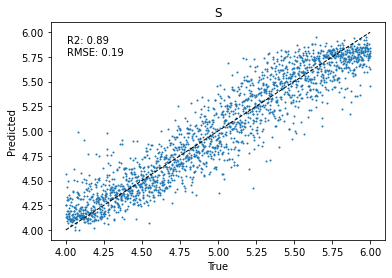

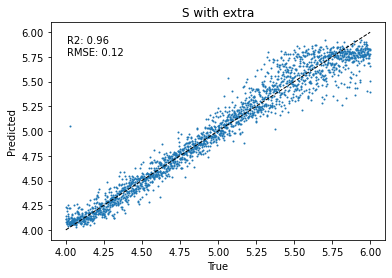

In [32]:
y_pred_S = dtr_S.predict(ps_test)
y_pred_S_with_extra = dtr_S_with_extra.predict(total_S_test)

prediction_plots(y_test[:, param_idx], y_pred_S, 'S')
prediction_plots(y_test[:, param_idx], y_pred_S_with_extra, 'S with extra')

### sbi

In [33]:
import warnings
warnings.filterwarnings('ignore')
import matplotlib.colors as mcolors

import ili
from ili.dataloaders import NumpyLoader
from ili.inference import InferenceRunner
from ili.validation.metrics import PosteriorCoverage, PlotSinglePosterior

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Device:', device)

Device: cuda


In [34]:
ps_train = np.load('/home/suice/workspace/play_ground/dataset/train_data/final_data/ps_train.npy')
extra_S_train = np.load(os.path.join(out_dir,'ba_extra_2_train.npy'))
y_train = np.load('/home/suice/workspace/play_ground/dataset/train_data/final_data/params_train.npy')
total_S_train = np.concatenate([ps_train,extra_S_train],axis=1)

ps_test = np.load('/home/suice/workspace/play_ground/dataset/train_data/final_data/ps_test.npy')
extra_S_test = np.load(os.path.join(out_dir,'ba_extra_2_test.npy'))
y_test = np.load('/home/suice/workspace/play_ground/dataset/train_data/final_data/params_test.npy')
total_S_test = np.concatenate([ps_test,extra_S_test],axis=1)

#### sbi ps

In [35]:
loader = NumpyLoader(x=ps_train, theta=y_train)

In [36]:
# define a prior
prior = ili.utils.Uniform(low=[1, 4], high=[2.4, 6], device=device)

# instantiate your neural networks to be used as an ensemble
nets = [
    ili.utils.load_nde_sbi(engine='NPE', model='maf', hidden_features=50, num_transforms=5),
]

# define training arguments
train_args = {
    'training_batch_size': 32,
    'learning_rate': 1e-4
}

# initialize the trainer
runner = InferenceRunner.load(
    backend='sbi',
    engine='NPE',
    prior=prior,
    nets=nets,
    device=device,
    embedding_net=None,
    train_args=train_args,
    proposal=None,
    out_dir=None
)

In [37]:
# train the model
posterior_ensemble, summaries = runner(loader=loader)

INFO:root:MODEL INFERENCE CLASS: NPE
INFO:root:Training model 1 / 1.


 Neural network successfully converged after 189 epochs.

INFO:root:It took 713.9237082004547 seconds to train models.


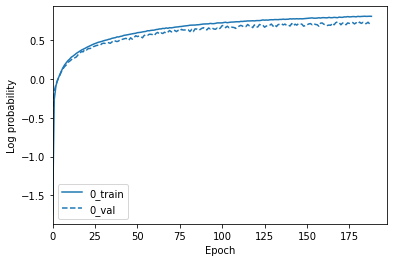

In [38]:
# plot train/validation loss
fig, ax = plt.subplots(1, 1, figsize=(6,4))
c = list(mcolors.TABLEAU_COLORS)
for i, m in enumerate(summaries):
    ax.plot(m['training_log_probs'], ls='-', label=f"{i}_train", c=c[i])
    ax.plot(m['validation_log_probs'], ls='--', label=f"{i}_val", c=c[i])
ax.set_xlim(0)
ax.set_xlabel('Epoch')
ax.set_ylabel('Log probability')
ax.legend()

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

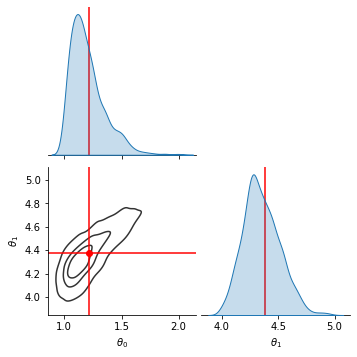

In [39]:
ind = 0
# use ltu-ili's built-in validation metrics to plot the posterior for this point
metric = PlotSinglePosterior(
    num_samples=1000, sample_method='direct', 
    labels=[f'$\\theta_{i}$' for i in range(2)]
)
fig = metric(
    posterior=posterior_ensemble,
    x_obs = ps_test[ind], theta_fid=y_test[ind]
)

100%|██████████| 2048/2048 [00:20<00:00, 102.32it/s]


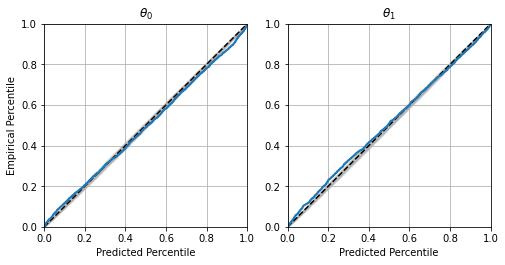

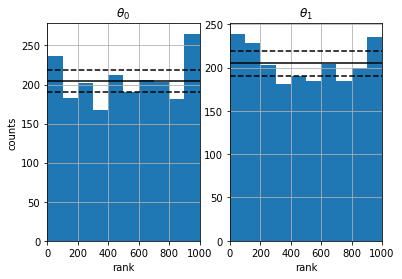

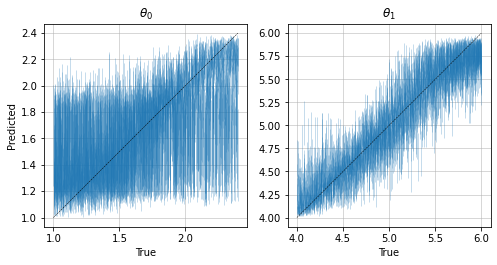

In [40]:
# Drawing samples from the ensemble posterior

metric = PosteriorCoverage(
    num_samples=1000, sample_method='direct', 
    labels=[f'$\\theta_{i}$' for i in range(2)],
    plot_list = ["coverage", "histogram", "predictions"],
    out_dir=None
)

fig = metric(
    posterior=posterior_ensemble, # NeuralPosteriorEnsemble instance from sbi package
    x=ps_test, theta=y_test
)

In [42]:
import pickle
import json

In [43]:
str_p = 'ps_posterior_ensemble.pkl'
str_s = 'ps_summaries.json'
with open(os.path.join(out_dir,str_p), "wb") as handle:
    pickle.dump(posterior_ensemble, handle)
with open(os.path.join(out_dir,str_s), "w") as handle:
    json.dump(summaries, handle)

#### sbi ps+extra

In [44]:
loader = NumpyLoader(x=total_S_train, theta=y_train)

In [45]:
# define a prior
prior = ili.utils.Uniform(low=[1, 4], high=[2.4, 6], device=device)

# instantiate your neural networks to be used as an ensemble
nets = [
    ili.utils.load_nde_sbi(engine='NPE', model='maf', hidden_features=50, num_transforms=5),
]

# define training arguments
train_args = {
    'training_batch_size': 32,
    'learning_rate': 1e-4
}

# initialize the trainer
runner = InferenceRunner.load(
    backend='sbi',
    engine='NPE',
    prior=prior,
    nets=nets,
    device=device,
    embedding_net=None,
    train_args=train_args,
    proposal=None,
    out_dir=None
)

In [46]:
# train the model
posterior_ensemble, summaries = runner(loader=loader)

INFO:root:MODEL INFERENCE CLASS: NPE
INFO:root:Training model 1 / 1.


 Training neural network. Epochs trained: 87

INFO:root:It took 333.3666934967041 seconds to train models.


 Neural network successfully converged after 88 epochs.

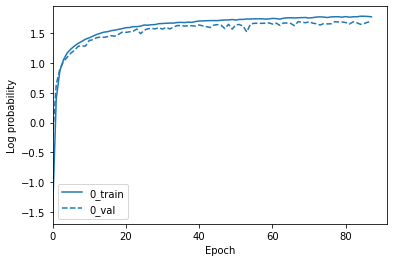

In [47]:
# plot train/validation loss
fig, ax = plt.subplots(1, 1, figsize=(6,4))
c = list(mcolors.TABLEAU_COLORS)
for i, m in enumerate(summaries):
    ax.plot(m['training_log_probs'], ls='-', label=f"{i}_train", c=c[i])
    ax.plot(m['validation_log_probs'], ls='--', label=f"{i}_val", c=c[i])
ax.set_xlim(0)
ax.set_xlabel('Epoch')
ax.set_ylabel('Log probability')
ax.legend()

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

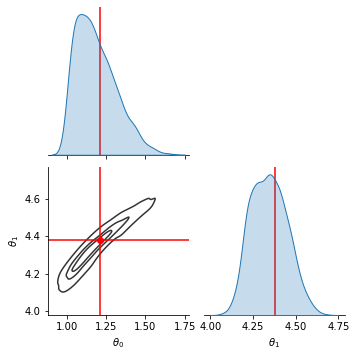

In [48]:
ind = 0
# use ltu-ili's built-in validation metrics to plot the posterior for this point
metric = PlotSinglePosterior(
    num_samples=1000, sample_method='direct', 
    labels=[f'$\\theta_{i}$' for i in range(2)]
)
fig = metric(
    posterior=posterior_ensemble,
    x_obs = total_S_test[ind], theta_fid=y_test[ind]
)

100%|██████████| 2048/2048 [00:18<00:00, 108.60it/s]


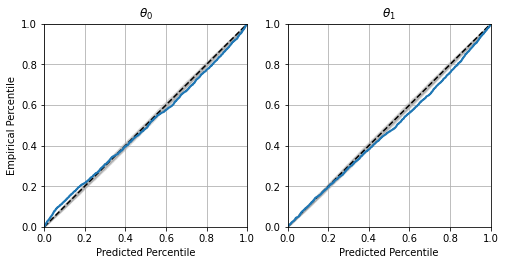

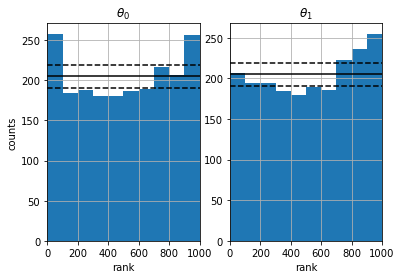

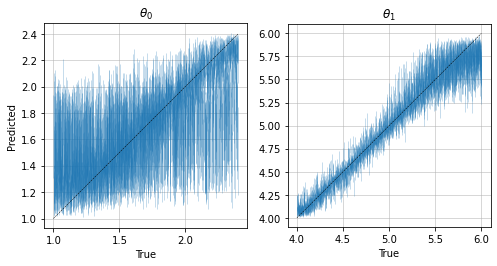

In [49]:
# Drawing samples from the ensemble posterior

metric = PosteriorCoverage(
    num_samples=1000, sample_method='direct', 
    labels=[f'$\\theta_{i}$' for i in range(2)],
    plot_list = ["coverage", "histogram", "predictions"],
    out_dir=None
)

fig = metric(
    posterior=posterior_ensemble, # NeuralPosteriorEnsemble instance from sbi package
    x=total_S_test, theta=y_test
)

In [50]:
str_p = 'ps_withba_extra_posterior_ensemble.pkl'
str_s = 'ps_withba_extra_summaries.json'
with open(os.path.join(out_dir,str_p), "wb") as handle:
    pickle.dump(posterior_ensemble, handle)
with open(os.path.join(out_dir,str_s), "w") as handle:
    json.dump(summaries, handle)

## Make Comparison

In [51]:
ps_test = np.load('/home/suice/workspace/play_ground/dataset/train_data/final_data/ps_test.npy')
y_test = np.load('/home/suice/workspace/play_ground/dataset/train_data/final_data/params_test.npy')

extra_S_EPE_test = np.load(os.path.join(out_dir,'ba_extra_2_test.npy'))
total_S_EPE_test = np.concatenate([ps_test,extra_S_EPE_test],axis=1)

# to tensor 
ps_test = torch.tensor(ps_test, dtype=torch.float32).to(device)
y_test = torch.tensor(y_test, dtype=torch.float32).to(device)
extra_S_EPE_test = torch.tensor(extra_S_EPE_test, dtype=torch.float32).to(device)
total_S_EPE_test = torch.tensor(total_S_EPE_test, dtype=torch.float32).to(device)

In [84]:
ps_posmodel_path = os.path.join(out_dir,'ps_posterior_ensemble.pkl')

with open(ps_posmodel_path, "rb") as handle:
    posterior_ensemble_ps = pickle.load(handle)


extra_posmodel_path = os.path.join(out_dir,'ps_withba_extra_posterior_ensemble.pkl')

with open(extra_posmodel_path, "rb") as handle:
    posterior_ensemble_epe = pickle.load(handle)

In [87]:
test_idx = np.random.randint(len(ps_test))
print('Test idx:', test_idx)

epe_pos = posterior_ensemble_epe.sample((1000,),x= total_S_EPE_test[test_idx]).detach().cpu().numpy()
ps_pos = posterior_ensemble_ps.sample((1000,),x= ps_test[test_idx]).detach().cpu().numpy()

Test idx: 1942


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

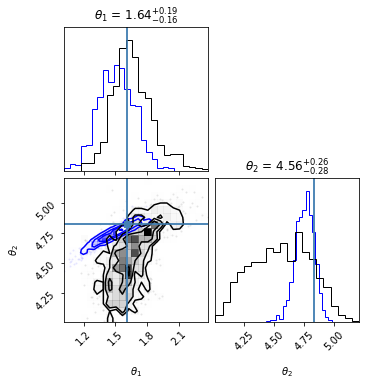

In [88]:
fig = corner(epe_pos, labels=[r"$\theta_1$", r"$\theta_2$"], truths=y_test[test_idx].cpu().numpy(), show_titles=True, title_kwargs={"fontsize": 12},color='blue');
corner(ps_pos, labels=[r"$\theta_1$", r"$\theta_2$"], truths=y_test[test_idx].cpu().numpy(), show_titles=True, title_kwargs={"fontsize": 12}, fig=fig,color='black');